# Análisis Exploratorio de Datos

En este notebook vamos a centrarnos en la exploración de las distintas variables que tenemos para predecir nuestra variable objetivo (Frio KW) y en el análisis de esta última. Todo esto con el fin de intentar detectar de forma temprana las posibles características que tengan mayor influencia en la predicción.

## 1. Exploración superficial de los crudos (.xlsx)

En este primer pantallazo no resulta interesante conocer un poco sobre qué información presenta cada hoja del archivo.

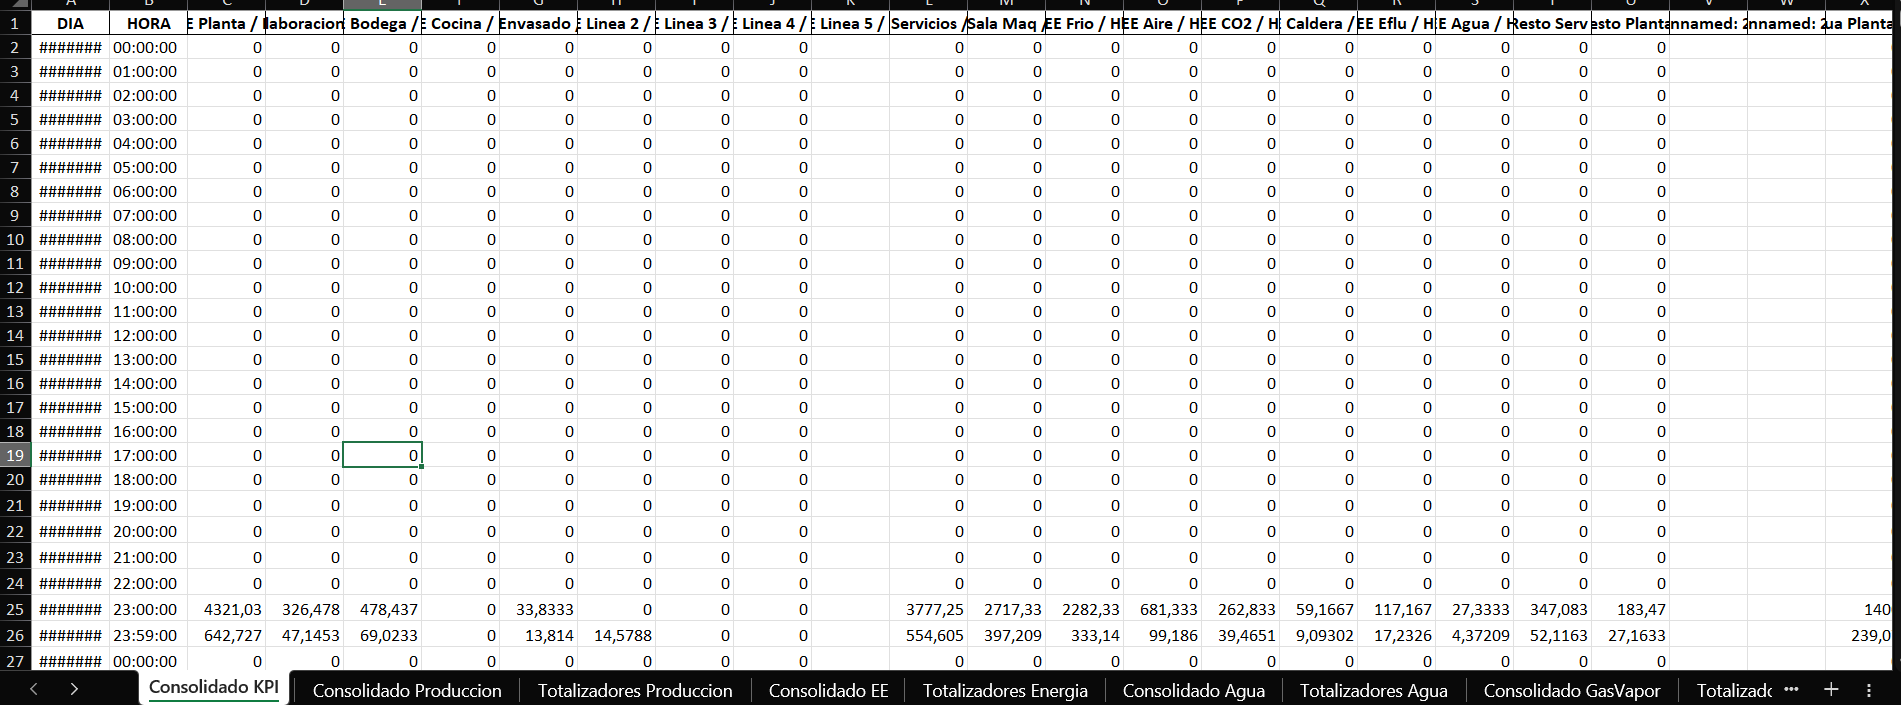

Mirando los nombres de las distintas hojas nos dimos cuenta que varias de ellas poseen 2 versiones:

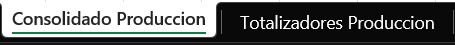

Lo que disparó la pregunta **¿Qué diferencia hay entre Consolidado y Totalizadores?**

Investigando un poco llegamos a la conclusión de que las hojas **Consolidado** son una especie de resumen filtrado y menos detallado de **Totalizadores**, esto normalmente se usa en las empresas para que gerentes o empleados que no están trabajando particularmente en la planta puedan ver los datos sin tanto ruido visual.

Esto ya nos lelvó a tomar una decisión. Siempre que sea posible (o sea, que exista) vamos a **usar la versión de Consolidado**.

Luego nos surgieron las típicas preguntas de: *"¿Qué significa esto? ¿Y esto otro?"*

Así que acá va un breve detalle de lo que significan algunas de las hojas:

- **KPI:** Son metricas de eficiencia creadas a partir de variables presentes en otras hojas.
- **Glicol:** Es el fluido refrigerante utilizado por el sistema de refrigeración.
- **Efluentes:** Son las aguas residuales de la planta. El proceso cervecero genera muchos residuos líquidos que deben ser tratados antes de ser descargados.
- **CO2:** Dióxido de carbono. En una cervecera, es crucial.

Una vez conocido lo que contienen nuestros crudos, pasamos a la siguiente etapa de decisión.

### ¿Qué vamos a extraer y por qué?

Para esto analizamos que más sencillo mirar lo que **NO** queríamos y el por qué, así que la decisión final fue lo siguiente:

Vamos a quedarnos con **todos los Consolidados** (justificado más arriba), y vamos a descartar las siguientes variables:

1. **KPI:** Al estar constituida por información de otras hojas existe la posibilidad de estar usando el *target para predecir el target*, o sea, ¡DATA LEAKAGE!
2. **Efluentes:** La hoja Consolidado EE ya tiene Efluentes (Kw) (la energía usada para tratarlos) y al ser un predictor menos directo podría añadir "ruido".

Quedando nuestra *lista de extracción* de esta forma:
- Consolidado EE
- Consolidado Produccion
- Totalizadores Energia
- Consolidado Agua
- Consolidado GasVapor
- Consolidado Aire
- Totalizadores Glicol
- Totalizadores CO2

---

## 2. Análisis Descriptivo y Versionado Inicial de Datos

### Implementación de la extracción de características de los archivos .xlsx utilizando openpyxl

In [15]:
# Seteo inicial

import logging
import warnings
from pathlib import Path

# Configuración de logging y advertencias
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
warnings.filterwarnings('ignore')

# Configuración de Paths

BASE_DIR = Path('../').resolve()
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'

PROCESSED_DIR.mkdir(exist_ok=True)

logging.info(f"Directorio Base: {BASE_DIR}")
logging.info(f"Directorio de Datos: {DATA_DIR}")
logging.info(f"Directorio Procesado: {PROCESSED_DIR}")

2025-11-06 00:15:14,227 - Directorio Base: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF
2025-11-06 00:15:14,227 - Directorio de Datos: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF\data
2025-11-06 00:15:14,228 - Directorio Procesado: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF\data\processed


In [16]:
# -- Función Modular de Carga y Filtrado ---

import openpyxl
import pandas as pd

def procesar_hoja_excel(sheet_name: str, excel_files: list[str], data_dir: Path) -> pd.DataFrame:
    """
    Carga una hoja específica de múltiples archivos Excel, 
    los unifica y aplica el filtrado diario (último registro).
    """
    
    all_dfs = []
    logging.info(f"--- Iniciando procesamiento para Hoja: '{sheet_name}' ---")
    
    for file_name in excel_files:
        file_path = data_dir / file_name
        if not file_path.exists():
            logging.warning(f"No se encontró el archivo: {file_path}")
            continue
        
        try:
            logging.info(f"Leyendo: {file_name}...")
            # Usamos pd.read_excel directamente sobre el .xlsx
            df = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
            all_dfs.append(df)
        except Exception as e:
            # Captura errores comunes como "hoja no encontrada"
            logging.error(f"Error en {file_name} (Hoja: {sheet_name}): {e}")

    if not all_dfs:
        logging.error(f"No se pudieron cargar datos para la hoja '{sheet_name}'. Se omitirá.")
        return pd.DataFrame()

    # Concatenar todos los DataFrames horarios
    df_hourly = pd.concat(all_dfs, ignore_index=True)

    # --- Aplicar Filtrado Diario (Totalizadores) ---
    try:
        df_hourly['timestamp'] = pd.to_datetime(
            pd.to_datetime(df_hourly['DIA']).dt.strftime('%Y-%m-%d') + ' ' + df_hourly['HORA']
        )
    except Exception:
        df_hourly['timestamp'] = pd.to_datetime(df_hourly['DIA'])
    
    df_hourly_sorted = df_hourly.sort_values(by='timestamp')
    
    # 3. Agrupar por fecha (del 'DIA') y tomar el ÚLTIMO registro
    df_daily = df_hourly_sorted.groupby(df_hourly_sorted['DIA']).last().reset_index()
    
    # 4. Limpieza y seteo de índice
    df_daily = df_daily.rename(columns={'timestamp': 'Fecha'})
    df_daily['Fecha'] = pd.to_datetime(df_daily['Fecha'])
    df_daily = df_daily.set_index('Fecha')

    columnas_a_eliminar = [col for col in df_daily.columns if str(col).startswith('Unnamed')] + ['Id','DIA', 'HORA']
    df_daily = df_daily.drop(columns=columnas_a_eliminar, errors='ignore')
    
    logging.info(f"Procesamiento para '{sheet_name}' completado. {df_daily.shape[0]} días unificados.")
    
    return df_daily

In [17]:
# -- Ejecución del Procesamiento ---

# 1. Definir los archivos Excel fuente (los originales .xlsx)
excel_files_list = [
    'TotalizadoresPlantaCerveza2020_2021.xlsx',
    'TotalizadoresPlantaCerveza2021_2022.xlsx',
    'TotalizadoresPlantaCerveza2022_2023.xlsx',
]

# 2. Definir todas las hojas que queremos procesar (TU LISTA)
hojas_a_procesar = [
    'Consolidado EE',           # Target Frio (Kw)
    'Totalizadores Energia',    # Detalle de compresores KW Mycom 1-7
    'Consolidado Produccion',
    'Consolidado Agua',
    'Consolidado GasVapor',
    'Consolidado Aire',
    'Totalizadores Glicol',
    'Totalizadores CO2'
]

# 3. Procesar todas las hojas y guardarlas en un diccionario
dataframes_diarios = {}
for hoja in hojas_a_procesar:
    df_hoja = procesar_hoja_excel(
        sheet_name=hoja,
        excel_files=excel_files_list,
        data_dir=DATA_DIR
    )
    if not df_hoja.empty:
        dataframes_diarios[hoja] = df_hoja

2025-11-06 00:15:14,247 - --- Iniciando procesamiento para Hoja: 'Consolidado EE' ---
2025-11-06 00:15:14,247 - Leyendo: TotalizadoresPlantaCerveza2020_2021.xlsx...
2025-11-06 00:15:34,753 - Leyendo: TotalizadoresPlantaCerveza2021_2022.xlsx...
2025-11-06 00:15:58,218 - Leyendo: TotalizadoresPlantaCerveza2022_2023.xlsx...
2025-11-06 00:16:16,476 - Procesamiento para 'Consolidado EE' completado. 1190 días unificados.
2025-11-06 00:16:16,477 - --- Iniciando procesamiento para Hoja: 'Totalizadores Energia' ---
2025-11-06 00:16:16,478 - Leyendo: TotalizadoresPlantaCerveza2020_2021.xlsx...
2025-11-06 00:16:39,784 - Leyendo: TotalizadoresPlantaCerveza2021_2022.xlsx...
2025-11-06 00:17:05,854 - Leyendo: TotalizadoresPlantaCerveza2022_2023.xlsx...
2025-11-06 00:17:26,836 - Procesamiento para 'Totalizadores Energia' completado. 1190 días unificados.
2025-11-06 00:17:26,843 - --- Iniciando procesamiento para Hoja: 'Consolidado Produccion' ---
2025-11-06 00:17:26,844 - Leyendo: TotalizadoresPlanta

In [18]:
# -- Unificación y Guardado ---

if not dataframes_diarios or 'Consolidado EE' not in dataframes_diarios:
    logging.error("No se pudo generar el dataset final. 'Consolidado EE' es obligatorio.")
else:
    logging.info(f"Se procesaron {len(dataframes_diarios)} hojas. Uniendo...")

    # Convertir el diccionario de dataframes en una lista
    df_list = list(dataframes_diarios.values())

    # Tomar el primer dataframe (Consolidado EE) como base
    df_final = dataframes_diarios.pop('Consolidado EE')

    # Hacer merge iterativo con el resto de dataframes
    for nombre_hoja, df_feature in dataframes_diarios.items():
        logging.info(f"Uniendo con: {nombre_hoja}")

        df_final = pd.merge(
            df_final,
            df_feature,
            left_index=True,
            right_index=True,
            how='left',
            # Añadir sufijos solo si hay colisiones
            suffixes=('', f'_{nombre_hoja}')
        )

    OUTPUT_FILE = PROCESSED_DIR / 'dataset_v01.csv'
    df_final.to_csv(OUTPUT_FILE)

    logging.info(f"Dataset v01 guardado en: {OUTPUT_FILE}!")
    print(f"\\nForma del dataset: {df_final.shape}")

2025-11-06 00:23:43,114 - Se procesaron 8 hojas. Uniendo...
2025-11-06 00:23:43,115 - Uniendo con: Totalizadores Energia
2025-11-06 00:23:43,118 - Uniendo con: Consolidado Produccion
2025-11-06 00:23:43,119 - Uniendo con: Consolidado Agua
2025-11-06 00:23:43,123 - Uniendo con: Consolidado GasVapor
2025-11-06 00:23:43,125 - Uniendo con: Consolidado Aire
2025-11-06 00:23:43,128 - Uniendo con: Totalizadores Glicol
2025-11-06 00:23:43,130 - Uniendo con: Totalizadores CO2
2025-11-06 00:23:43,250 - Dataset v01 guardado en: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF\data\processed\dataset_v01.csv!


\nForma del dataset: (1190, 149)


### Sistema de checksums

In [19]:
# -- Función para calcular checksums ---

import hashlib

def calculate_checksum(file_path: Path) -> str:
    """Calcula el hash SHA256 de un archivo."""
    sha256 = hashlib.sha256()
    with open(file_path, 'rb') as f:
        while chunk := f.read(8192):
            sha256.update(chunk)
    return sha256.hexdigest()

In [20]:
# -- Guardado del Checksum ---

import json

# 1. Calcular el checksum del NUEVO archivo
new_checksum_val = calculate_checksum(OUTPUT_FILE)

CHECKSUM_FILE = DATA_DIR / 'checksums.json'
checksums_data = {}

# 2. Cargar el JSON existente
if CHECKSUM_FILE.exists():
    with open(CHECKSUM_FILE, 'r') as f:
        try:
            checksums_data = json.load(f)
        except json.JSONDecodeError:
            logging.warning("Advertencia: 'checksums.json' está corrupto.")

# 3. Actualizar el checksum
key = str(OUTPUT_FILE.relative_to(BASE_DIR)).replace('\\', '/')
checksums_data[key] = new_checksum_val

# 4. Guardar el JSON actualizado
with open(CHECKSUM_FILE, 'w') as f:
    json.dump(checksums_data, f, indent=4)

print(f"\n--- Checksum (SHA256) Actualizado ---")
print(f"Archivo: {key}")
print(f"Nuevo Checksum: {new_checksum_val}")
print(f"'checksums.json' actualizado.")


--- Checksum (SHA256) Actualizado ---
Archivo: data/processed/dataset_v01.csv
Nuevo Checksum: 9599c51653fedcf111ef11c4709062de741506d70a254ae01162ca60431b6f63
'checksums.json' actualizado.


### Dimensiones del dataset completo

In [28]:
df_final.shape

(1190, 149)

### Tipos de variables y rangos de valores.

In [29]:
df_final.info()
print()
display(df_final.describe().T.round(2))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1190 entries, 2020-07-01 23:59:00 to 2023-10-26 07:00:00
Columns: 149 entries, Planta (Kw) to Totalizador_Filtracion
dtypes: float64(144), int64(4), object(1)
memory usage: 1.4+ MB



,count,mean,std,min,25%,50%,75%,max
Planta (Kw),1190.0,6.555813e+04,7.015841e+04,8987.48,51584.23,66827.92,76450.47,2.412967e+06
Elaboracion (Kw),1190.0,6.939790e+03,1.948200e+03,-672.00,5709.50,7122.50,8352.50,1.157500e+04
Bodega (Kw),1190.0,5.951030e+03,1.831250e+03,-6247.00,4847.62,6086.12,7192.12,1.691800e+04
Cocina (Kw),1190.0,1.717150e+03,6.993000e+02,76.00,1259.25,1965.00,2232.75,3.125000e+03
Envasado (Kw),1190.0,2.753613e+13,9.498969e+14,347.00,9765.25,16346.00,19045.75,3.276800e+16
...,...,...,...,...,...,...,...,...
Totalizador_L3,1189.0,1.237110e+03,1.429150e+03,0.00,81.00,1342.00,1691.00,1.267000e+04
Totaliador_Latas,1189.0,3.847570e+03,2.095390e+03,0.00,2670.00,4786.00,5324.00,6.663000e+03
Totalizador_Bodega,1189.0,3.450460e+03,1.815030e+03,0.00,2315.19,3481.50,4605.34,1.242181e+04
Totalizador_Tq_Pulmon,1189.0,1.101340e+04,2.416003e+04,-805849.00,8764.00,12645.00,15148.00,2.378700e+04


In [30]:
# Detallado de la variable objetivo (Frío)

display(df_final['Frio (Kw)'].describe().T)

count    1.190000e+03
mean     3.345313e+04
std      2.397688e+05
min      2.310000e+03
25%      1.794200e+04
50%      2.368650e+04
75%      2.932250e+04
max      6.155928e+06
Name: Frio (Kw), dtype: float64

### Identificación y cuantificación de valores faltantes.

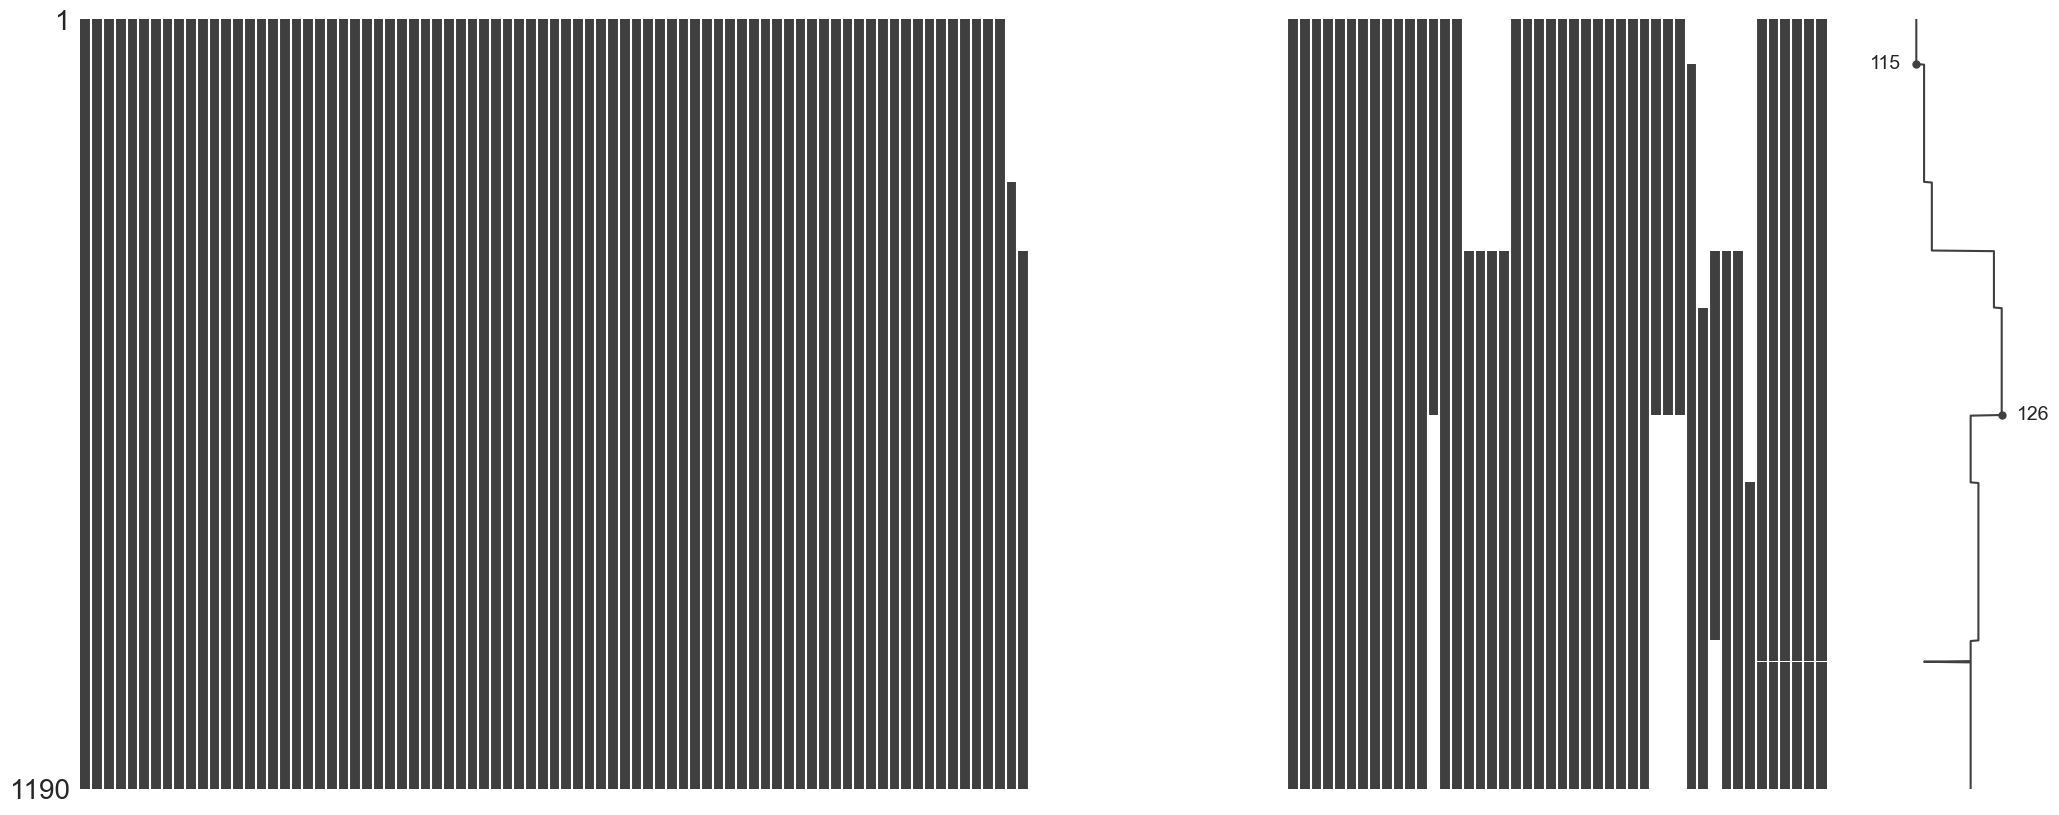

In [31]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_final)
plt.show()

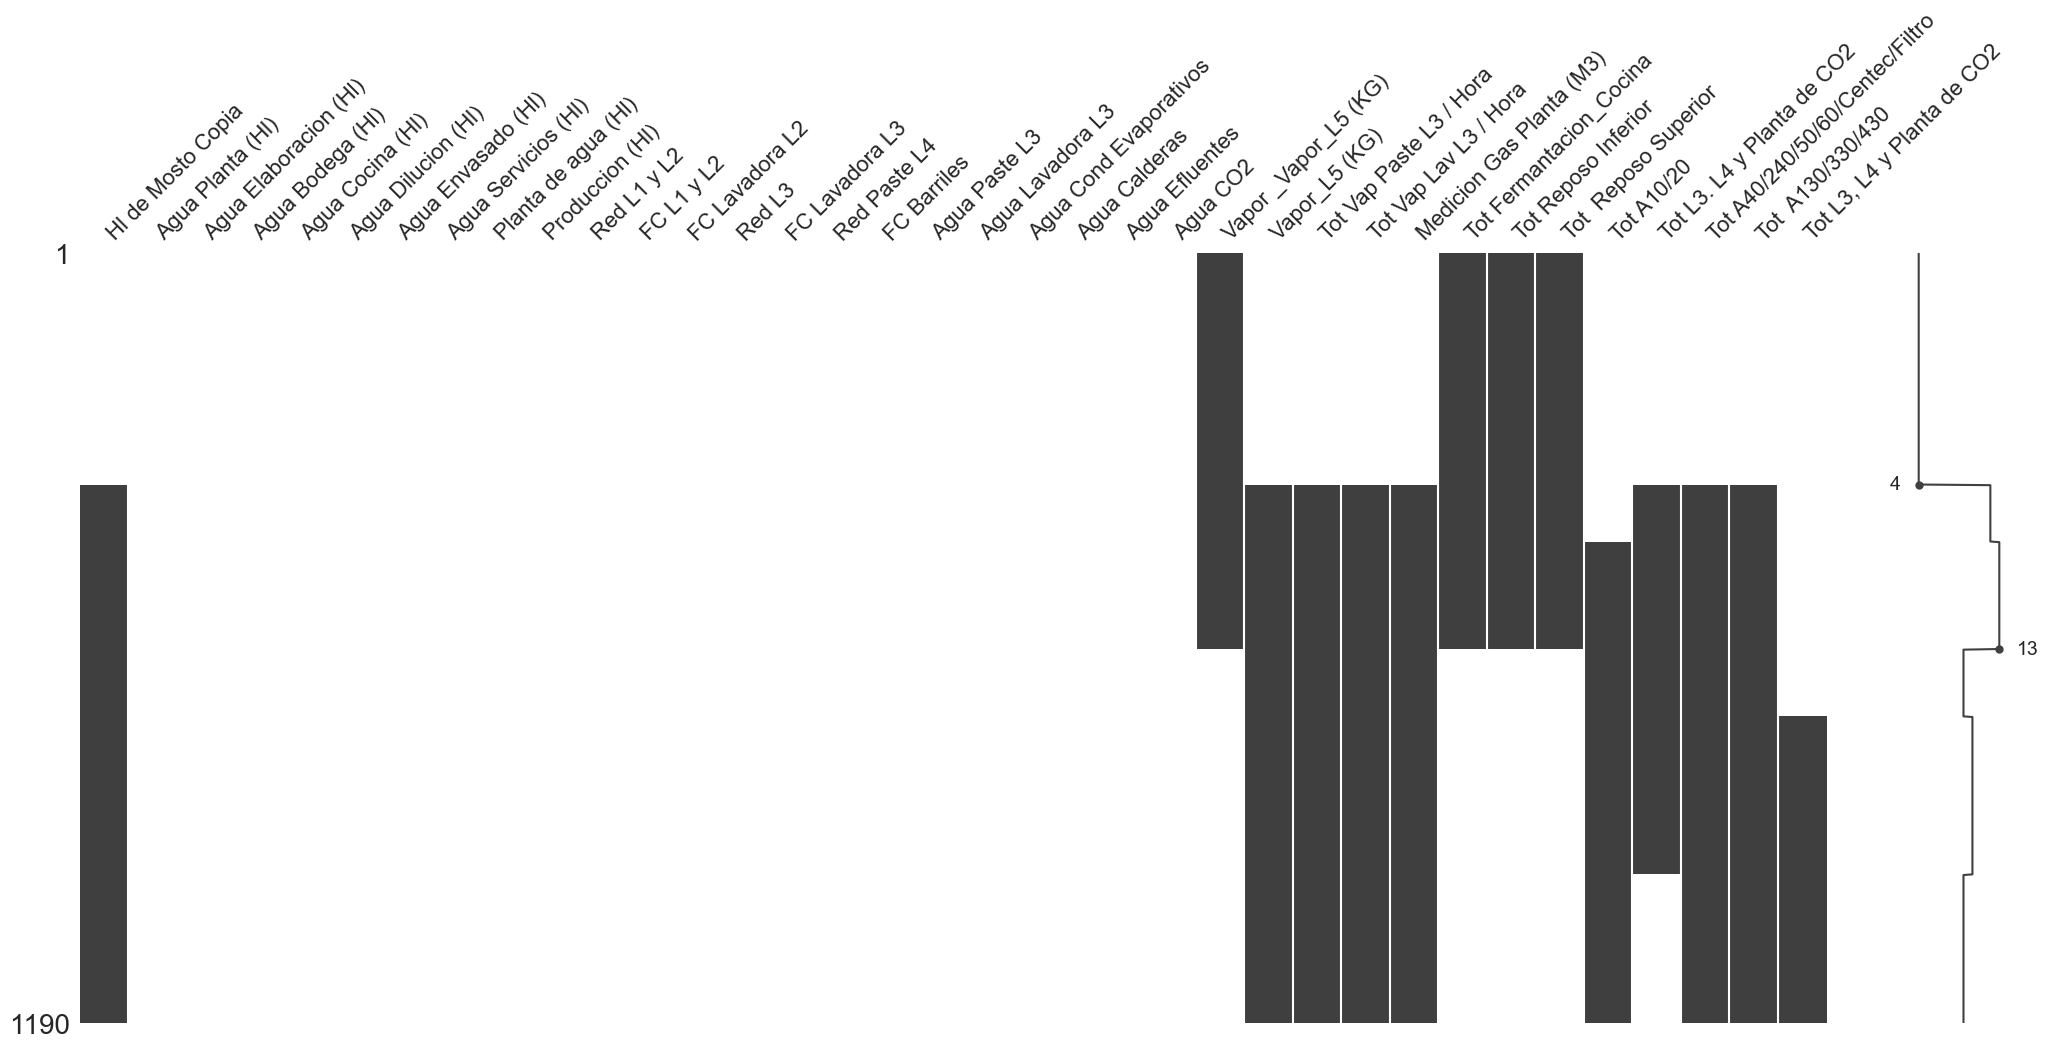

In [32]:
# Zoom a las variables con más del 30% de datos faltantes

msno.matrix(
    df_final.loc[:, df_final.isnull().mean() > 0.3]
)
plt.show()

### Detección de valores atípicos y errores (#VALUE!, #DIV/0!, etc.)

In [33]:
# Cuantificar cantidad de valores atípicos por columna usando el método del IQR

outliers_summary = {}
for column in df_final.select_dtypes(include=['number']).columns:
    Q1 = df_final[column].quantile(0.25)
    Q3 = df_final[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_final[(df_final[column] < lower_bound) | (df_final[column] > upper_bound)]
    outliers_summary[column] = {
        'num_outliers': outliers.shape[0],
        'percentage_outliers': (outliers.shape[0] / df_final.shape[0]) * 100
    }

outliers_df = pd.DataFrame(outliers_summary).T
outliers_df = outliers_df.sort_values(by='percentage_outliers', ascending=False)

display(outliers_df.round(2))

,num_outliers,percentage_outliers
Totalizador_L2_Barriles,282.0,23.70
VAPOR DE LINEA 4 KG,229.0,19.24
Totaliador_Aire_L4,222.0,18.66
KW Filtr Carbon,200.0,16.81
Linea 4 (Kw),188.0,15.80
...,...,...
Totalizador_Aire_L5,0.0,0.00
Tot A10/20,0.0,0.00
Tot Reposo Inferior,0.0,0.00
Totaliador_Latas,0.0,0.00


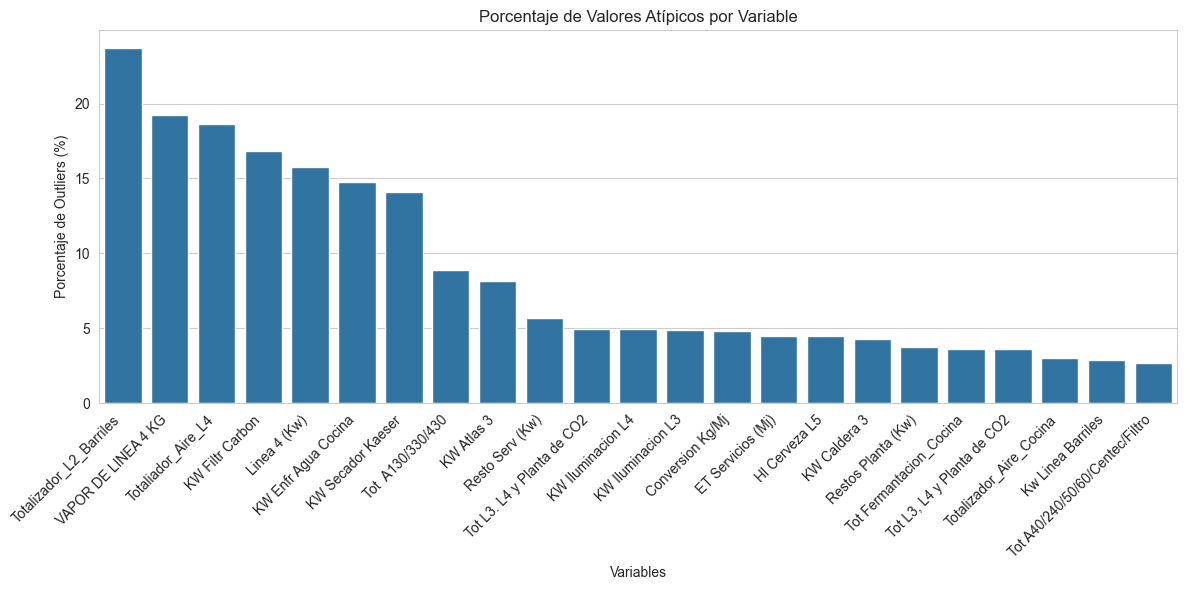

In [35]:
# Mostrar el resumen de outliers en un gráfico de barras

import seaborn as sns
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))
outliers_df = outliers_df[outliers_df['num_outliers'] > 30]     # Filtrar solo variables con más de 30 outliers
sns.barplot(x=outliers_df.index, y='percentage_outliers', data=outliers_df)
plt.xticks(rotation=45, ha='right')
plt.title('Porcentaje de Valores Atípicos por Variable')
plt.ylabel('Porcentaje de Outliers (%)')
plt.xlabel('Variables')
plt.tight_layout()
plt.show()

---